# Predicting diabetes risk

Diabetes is an extremely common chronic disease in the United States. It's also extremely taxing on the people who have it, both physically as well as economically. Given this, it might be worth exploring whether the risk of diabetes can be predicted with data. To explore the risk factors for diabetes, I will use the Behavioral Risk Factor Surveillance System (BRFSS) from 2015.

In this notebook, I will try to accomplish the suggested research questions provided on [Kaggle](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_012_health_indicators_BRFSS2015.csv): 


1. Can survey questions from the BRFSS provide accurate predictions of whether an individual has diabetes?
2. What risk factors are most predictive of diabetes risk?
3. Can we use a subset of the risk factors to accurately predict whether an individual has diabetes?



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [2]:
data = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

As a crude first pass, since I am dealing with ordinal and binary data, I can look at how they are related using a Spearman correlation.

<AxesSubplot:>

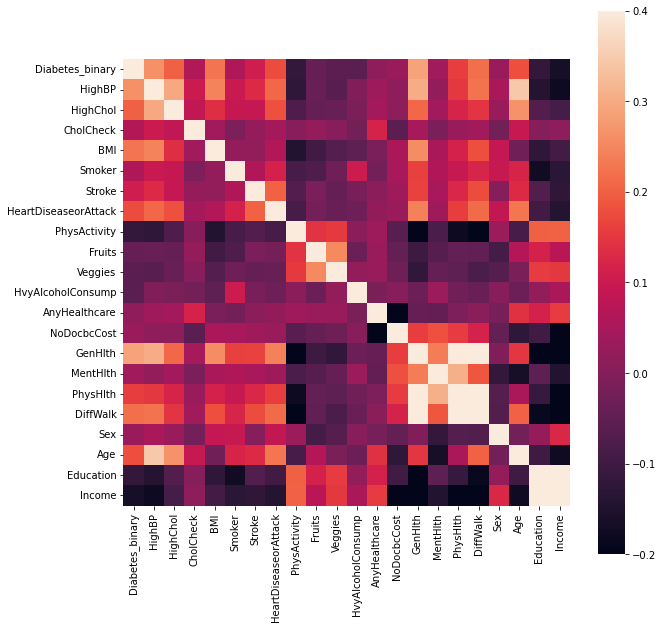

In [3]:
plt.figure(figsize=(10,10))
sns.heatmap(data=data.corr(method='spearman'),vmin = -0.2, vmax = 0.4, square=True)

Not surprisingly, diabetes is correlated with poor health markers such as high blood pressure, BMI and cholesterol, and with poor health behaviors such as smoking and lack of exercise. However there are no variables with clear outsized importance, suggesting that the causation of diabetes is complex and multifaceted.

## 1. Can survey questions accurately predict diabetes?

Since I am predicting a category for labeled data with a relatively large number of samples, I'll try using a simple neural network

In [4]:
X = data.drop(['Diabetes_binary'],axis=1)
X_sc = MinMaxScaler().fit_transform(X)
y = data['Diabetes_binary']

X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.20, random_state=123)

In [15]:
n = len(X.columns)
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(n,)))
model.add(tf.keras.layers.Dense(n*32,activation='relu'))
model.add(tf.keras.layers.Dense(n*16,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.summary()
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split = 0.33,epochs=20, batch_size = 256,verbose=1)
test_loss, test_acc = model.evaluate(X_test, y_test)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 672)               14784     
_________________________________________________________________
dense_13 (Dense)             (None, 336)               226128    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 337       
Total params: 241,249
Trainable params: 241,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
532/532 [==============================] - 2s 4ms/step - loss: 0.1017 - accuracy: 0.8627 - val_loss: 0.0991 - val_accuracy: 0.8650
Epoch 2/20
532/532 [==============================] - 2s 3ms/step - loss: 0.0977 - accuracy: 0.8655 - val_loss: 0.0998 - val_accuracy: 0.8650
Epoch 3/20
532/532 [==============================] - 2s 3ms/step - loss: 0.0973 - accuracy: 0

Text(0.5, 0, 'Epochs')

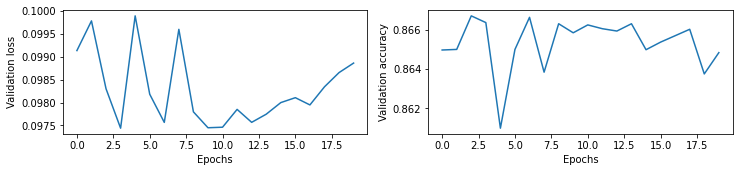

In [16]:
fig = plt.figure(figsize=(12,5))
plt.subplot(221)
plt.plot(history.history['val_loss'])
plt.ylabel('Validation loss')
plt.xlabel('Epochs')

plt.subplot(222)
plt.plot(history.history['val_accuracy'])
plt.ylabel('Validation accuracy')
plt.xlabel('Epochs')

The accuracy determined with the validation set sits at about 0.86 for all of the epochs, which appears OK. But let's look at the confusion matrix.

Text(33.0, 0.5, 'Actual')

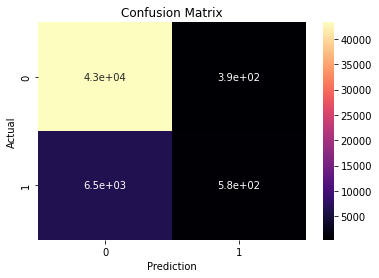

In [17]:
y_pred = model.predict(X_test)
conf_mat = metrics.confusion_matrix(y_test,np.round(y_pred))
sns.heatmap(conf_mat,annot=True,cmap='magma')
plt.title('Confusion Matrix')
plt.xlabel("Prediction")
plt.ylabel("Actual")

Even though the accuracy at first seems "decent", the confusion matrix is bad. There are just as many false positives as there are true positives. The chance of telling somebody that they have diabetes when they actually don't is equally likely. If we just created a model predicting that all the results were negative, what would we get?

In [18]:
np.sum(y==0)/np.size(y)

0.8606669820245979

This suggests that our fancy neural network model is not great at all, doing only 0.5% better than the most naive model imaginable. Perhaps the issue is that the model is only good at predicting true negatives, because that is usually what it sees. This is an intrinsic flaw in the input dataset, because it contains mostly negatives. To fix this, I need to rebalance it. The Kaggle page already provides this dataset, but I want to try doing it myself.

In [19]:
diabetes_group = data[data['Diabetes_binary']==1]
nodiabetes_group = data[data['Diabetes_binary']==0]
diabetes_group_oversampled = diabetes_group.sample(len(nodiabetes_group),replace=True) 

data_oversampled = pd.concat([diabetes_group_oversampled,nodiabetes_group],axis=0)

<AxesSubplot:title={'center':'After'}>

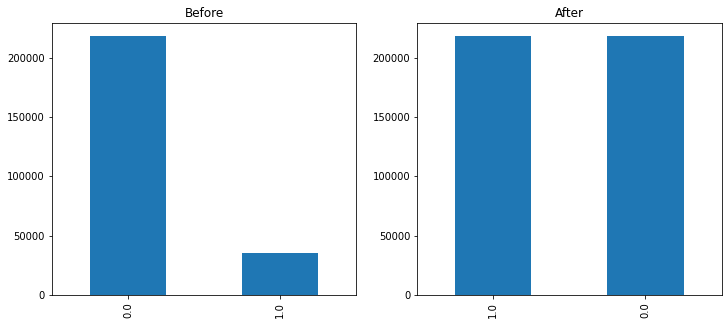

In [20]:
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
data['Diabetes_binary'].value_counts().plot(kind='bar',title='Before')
plt.subplot(122)
data_oversampled['Diabetes_binary'].value_counts().plot(kind='bar', title='After')

This is much better. Let's see if a neural network works better now....

In [21]:
X_os = data_oversampled.drop(['Diabetes_binary'],axis=1)
X_os_sc = MinMaxScaler().fit_transform(X_os)
y_os = data_oversampled['Diabetes_binary']
X_os_train, X_os_test, y_os_train, y_os_test =train_test_split(X_os_sc, y_os, test_size=0.20, random_state=123)

n = len(X.columns)
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(n,)))
model.add(tf.keras.layers.Dense(n*32,activation='relu'))
model.add(tf.keras.layers.Dense(n*16,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.summary()
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
history = model.fit(X_os_train, y_os_train, validation_split = 0.33,epochs=100, batch_size = 256,verbose=1)
test_loss, test_acc = model.evaluate(X_os_test, y_os_test)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 672)               14784     
_________________________________________________________________
dense_16 (Dense)             (None, 336)               226128    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 337       
Total params: 241,249
Trainable params: 241,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1717 - accuracy: 0.7453 - val_loss: 0.1700 - val_accuracy: 0.7480
Epoch 2/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1679 - accuracy: 0.7521 - val_loss: 0.1678 - val_accuracy: 0.7520
Epoch 3/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1667 - accuracy

Epoch 53/100
915/915 [==============================] - 3s 3ms/step - loss: 0.0778 - accuracy: 0.8991 - val_loss: 0.1242 - val_accuracy: 0.8385
Epoch 54/100
915/915 [==============================] - 3s 3ms/step - loss: 0.0767 - accuracy: 0.9006 - val_loss: 0.1233 - val_accuracy: 0.8384
Epoch 55/100
915/915 [==============================] - 3s 3ms/step - loss: 0.0757 - accuracy: 0.9021 - val_loss: 0.1256 - val_accuracy: 0.8380
Epoch 56/100
915/915 [==============================] - 3s 3ms/step - loss: 0.0746 - accuracy: 0.9038 - val_loss: 0.1242 - val_accuracy: 0.8398
Epoch 57/100
915/915 [==============================] - 3s 3ms/step - loss: 0.0739 - accuracy: 0.9043 - val_loss: 0.1238 - val_accuracy: 0.8399
Epoch 58/100
915/915 [==============================] - 3s 3ms/step - loss: 0.0729 - accuracy: 0.9057 - val_loss: 0.1237 - val_accuracy: 0.8404
Epoch 59/100
915/915 [==============================] - 3s 3ms/step - loss: 0.0720 - accuracy: 0.9075 - val_loss: 0.1217 - val_accuracy:

Text(0.5, 0, 'Epochs')

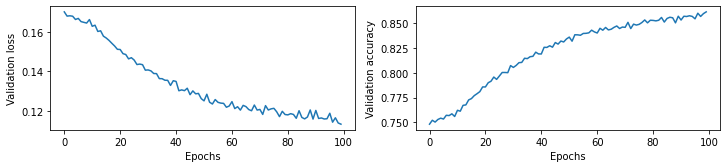

In [22]:
fig = plt.figure(figsize=(12,5))
plt.subplot(221)
plt.plot(history.history['val_loss'])
plt.ylabel('Validation loss')
plt.xlabel('Epochs')

plt.subplot(222)
plt.plot(history.history['val_accuracy'])
plt.ylabel('Validation accuracy')
plt.xlabel('Epochs')

Text(33.0, 0.5, 'Actual')

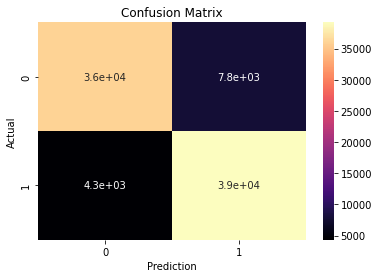

In [30]:
y_os_pred = model.predict(X_os_test)
conf_mat = metrics.confusion_matrix(y_os_test,np.round(y_os_pred))
sns.heatmap(conf_mat,annot=True,cmap='magma')
plt.title('Confusion Matrix')
plt.xlabel("Prediction")
plt.ylabel("Actual")

In [24]:
test_loss

0.11330721527338028

In [25]:
test_acc

0.861085057258606

This is a much better set of results. True positives and negatives are much more common than false positives and negatives. This is a much better score than the naive method used before would predict: 0.5 (since I artificially oversampled). From this, we can conclude that it is possible to predict diabetes relatively well with survey questions, provided that the dataset is over or undersampled such that the two outcomes are equally probable.

## 2. What risk factors are most predictive of diabetes risk?

There are a lot of ways I could do this. But since I am learning neural networks, let's try using a method that works with them called "permutation importance". This method tests a trained model on datasets where each feature's values are  shuffled to see how it affects the performance. By design, the method is biased toward features that are correlated, but all of the survey questions seem to imply a hypothesized correlation, so this shouldn't be a design flaw here.

I use the eli5 package to accomplish this, which is supposed to work better with sklearn models. I created a simple wrapper to get it to cooperate quickly.

In [42]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

def diabetes_model():
    n = len(X.columns)
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(n,)))
    model.add(tf.keras.layers.Dense(n*32,activation='relu'))
    model.add(tf.keras.layers.Dense(n*16,activation='relu'))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

In [43]:
my_model = KerasRegressor(build_fn=diabetes_model)
history = my_model.fit(X_os_train, y_os_train, validation_split = 0.33,epochs=100, batch_size = 256,verbose=1)

Epoch 1/100
915/915 [==============================] - 4s 4ms/step - loss: 0.1719 - accuracy: 0.7448 - val_loss: 0.1693 - val_accuracy: 0.7494
Epoch 2/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1677 - accuracy: 0.7519 - val_loss: 0.1683 - val_accuracy: 0.7511
Epoch 3/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1668 - accuracy: 0.7535 - val_loss: 0.1672 - val_accuracy: 0.7525
Epoch 4/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1659 - accuracy: 0.7547 - val_loss: 0.1715 - val_accuracy: 0.7447
Epoch 5/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1649 - accuracy: 0.7571 - val_loss: 0.1663 - val_accuracy: 0.7543
Epoch 6/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1641 - accuracy: 0.7582 - val_loss: 0.1655 - val_accuracy: 0.7554
Epoch 7/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1629 - accuracy: 0.7612 - val_loss: 0.1651 - val_accuracy: 0.7564

Epoch 58/100
915/915 [==============================] - 3s 3ms/step - loss: 0.0734 - accuracy: 0.9053 - val_loss: 0.1228 - val_accuracy: 0.8422
Epoch 59/100
915/915 [==============================] - 3s 3ms/step - loss: 0.0729 - accuracy: 0.9058 - val_loss: 0.1230 - val_accuracy: 0.8413
Epoch 60/100
915/915 [==============================] - 3s 3ms/step - loss: 0.0719 - accuracy: 0.9071 - val_loss: 0.1238 - val_accuracy: 0.8415
Epoch 61/100
915/915 [==============================] - 3s 3ms/step - loss: 0.0709 - accuracy: 0.9084 - val_loss: 0.1217 - val_accuracy: 0.8436
Epoch 62/100
915/915 [==============================] - 3s 3ms/step - loss: 0.0703 - accuracy: 0.9097 - val_loss: 0.1207 - val_accuracy: 0.8454
Epoch 63/100
915/915 [==============================] - 3s 3ms/step - loss: 0.0692 - accuracy: 0.9108 - val_loss: 0.1212 - val_accuracy: 0.8456
Epoch 64/100
915/915 [==============================] - 3s 3ms/step - loss: 0.0688 - accuracy: 0.9117 - val_loss: 0.1212 - val_accuracy:

In [44]:
perm = PermutationImportance(my_model, random_state=1).fit(X_os_test,y_os_test)
eli5.show_weights(perm, feature_names = X_os_test.columns.tolist())

2730/2730 [==============================] - 4s 1ms/step - loss: 0.1938 - accuracy: 0.7659


2730/2730 [==============================] - 4s 1ms/step - loss: 0.2119 - accuracy: 0.7445


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [48]:
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.1367 ± 0.0018,GenHlth
0.1130 ± 0.0007,BMI
0.1114 ± 0.0013,Age
0.0988 ± 0.0007,Income
0.0945 ± 0.0017,HighBP
0.0915 ± 0.0016,HighChol
0.0809 ± 0.0010,Sex
0.0803 ± 0.0010,PhysHlth
0.0793 ± 0.0013,Smoker
0.0760 ± 0.0023,Fruits


The importance of each feature seems to gradually decrease; there is no obvious cutoff. This result agrees with the correlation matrix we calculated above: there were no obvious features that stood above the rest. Let's try arbitrarily cutting off the data at the point where the relatively weight is about half of the top value. We can visualize these features easily with seaborn.

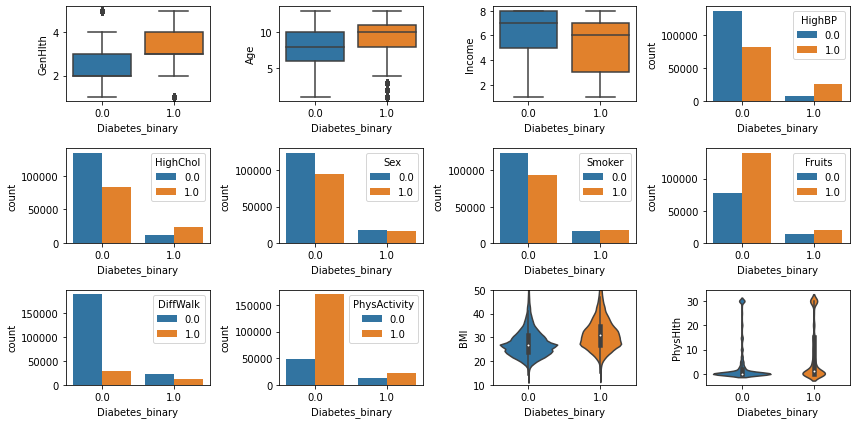

In [104]:
fig = plt.figure(figsize=(12,6))




for i,name in enumerate(['GenHlth','Age','Income']):
    plt.subplot(3,4,i+1)
    sns.boxplot(data=data,x='Diabetes_binary',y=name)

for i,name in enumerate(['HighBP','HighChol','Sex','Smoker','Fruits','DiffWalk','PhysActivity']):
    plt.subplot(3,4,i+4)
    sns.countplot(data=data,x='Diabetes_binary',hue=name)

plt.subplot(3,4,11)
sns.violinplot(data=data,x='Diabetes_binary',y='BMI')
plt.ylim(10,50)
plt.subplot(3,4,12)
sns.violinplot(data=data,x='Diabetes_binary',y='PhysHlth')
    
plt.tight_layout()


## 3. Can we use a subset of the risk factors to accurately predict whether an individual has diabetes?

Let's see if I can get a decent model working with only the top 12 risk factors.

In [88]:
X_sub = X_os[['HighBP','BMI','GenHlth','Age','Income','HighChol','Sex','PhysHlth','Smoker','Fruits','DiffWalk','PhysActivity']]
X_sub_sc = MinMaxScaler().fit_transform(X_sub)
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub_sc, y_os, test_size=0.20, random_state=123)

def simple_diabetes_model():
    n = len(X_sub.columns)
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(n,)))
    model.add(tf.keras.layers.Dense(n*32,activation='relu'))
    model.add(tf.keras.layers.Dense(n*16,activation='relu'))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

In [89]:
my_simple_model = KerasRegressor(build_fn=simple_diabetes_model)
history = my_simple_model.fit(X_sub_train, y_sub_train, validation_split = 0.33,epochs=100, batch_size = 256,verbose=1)

Epoch 1/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1737 - accuracy: 0.7411 - val_loss: 0.1714 - val_accuracy: 0.7459
Epoch 2/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1701 - accuracy: 0.7475 - val_loss: 0.1704 - val_accuracy: 0.7475
Epoch 3/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1695 - accuracy: 0.7488 - val_loss: 0.1714 - val_accuracy: 0.7459
Epoch 4/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1691 - accuracy: 0.7492 - val_loss: 0.1702 - val_accuracy: 0.7465
Epoch 5/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1687 - accuracy: 0.7503 - val_loss: 0.1707 - val_accuracy: 0.7474
Epoch 6/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1682 - accuracy: 0.7513 - val_loss: 0.1695 - val_accuracy: 0.7486
Epoch 7/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1680 - accuracy: 0.7522 - val_loss: 0.1695 - val_accuracy: 0.7487

Epoch 58/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1369 - accuracy: 0.8082 - val_loss: 0.1543 - val_accuracy: 0.7812
Epoch 59/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1361 - accuracy: 0.8095 - val_loss: 0.1547 - val_accuracy: 0.7801
Epoch 60/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1355 - accuracy: 0.8098 - val_loss: 0.1538 - val_accuracy: 0.7807
Epoch 61/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1351 - accuracy: 0.8110 - val_loss: 0.1537 - val_accuracy: 0.7826
Epoch 62/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1346 - accuracy: 0.8114 - val_loss: 0.1542 - val_accuracy: 0.7818
Epoch 63/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1339 - accuracy: 0.8128 - val_loss: 0.1545 - val_accuracy: 0.7821
Epoch 64/100
915/915 [==============================] - 3s 3ms/step - loss: 0.1336 - accuracy: 0.8138 - val_loss: 0.1536 - val_accuracy:

Text(0.5, 0, 'Epochs')

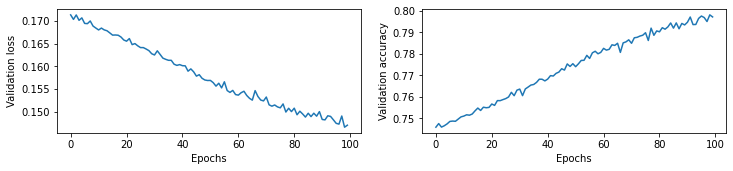

In [90]:
fig = plt.figure(figsize=(12,5))
plt.subplot(221)
plt.plot(history.history['val_loss'])
plt.ylabel('Validation loss')
plt.xlabel('Epochs')

plt.subplot(222)
plt.plot(history.history['val_accuracy'])
plt.ylabel('Validation accuracy')
plt.xlabel('Epochs')

Using half the features, we can get a model with about 80% accuracy. The accuracy decreased by about 5%, which is not bad, considering that the features we removed had significant weight values. 